In [22]:
import numpy as np
from random import seed
from random import randrange

from dataloader import load_data
from PCA import PCA as pca
import matplotlib.pyplot as plt 
import matplotlib
import random

In [2]:
def cross_val_one_class(k,dataset):
    k_sets = list()
    set_size = int(len(dataset)/k) 
    dataset_copy = list(dataset)
    
    for i in range(k-1):
        fold = list()
        while(len(fold)<set_size):
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        k_sets.append(fold)
        
    k_sets.append(dataset_copy)
        
    return k_sets

In [3]:
def cross_val_all_classes(k,dataset):
    k_sets = list()
    split = cross_val_one_class(k,dataset[0])
    
    for i in range(1,len(dataset)):
        split1 = cross_val_one_class(k,dataset[i])
        for j in range(k):
            split[j].extend(split1[j])
    
    return split        
        

In [4]:
def one_hot(Y):
    n = np.shape(Y)[0]
    one_hot_Y = np.zeros((n,4))
    
    for i in range(n):
        oh = np.zeros((1,4))
        if Y[i,0] == 0:
            oh[0,0] = 1
        elif Y[i,0]==1:
            oh[0,1] = 1
        elif Y[i,0] ==2:
            oh[0,2] = 1
        else :
            oh[0,3] = 1
        
        one_hot_Y[i,:] = oh
    
    return one_hot_Y
        
        

In [5]:
def softmax(X,W,b):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    
    n is the number of examples
    d is the dimension
    
    '''
    o = np.dot(X,W) + b # o has dimension nx4
    
    # y_hat is softmax of o
    
    exp_o = np.exp(o)
    exp_o_sum = np.sum(exp_o ,axis = 1,keepdims = True)
    
    y_hat = exp_o/exp_o_sum
    
    return y_hat

In [6]:
def initialize_parameters(d,c = 4):
    """
    d is the dimension of input x
    c is the number of classes in the output
    
    Returns:
    w -- initialized vector of shape (dim, c)
    b -- initialized bias, vector of shape (1,c) 
    
    """
    
    #w = np.zeros((d,c))
    w = np.random.randn(d,c) * 0.0001
    #print(w.shape)
    b =np.zeros((1,c))
    
    return w, b

In [7]:
def cost_function(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    cost/cross-entropy loss -- negative log-likelihood cost for softmax regression
    '''
    n = X.shape[0]
    
    y_hat = softmax(X,W,b)  # predicted probabilities for each class
    
    log_y_hat = np.log(y_hat)
    # add division by 4
    cost = -1.0*np.sum(np.multiply(Y,log_y_hat))
    avg_cost = cost/(4*n)
    avg_cost = np.squeeze(avg_cost)
    #print(avg_cost)
    
    return avg_cost
    

In [8]:
def gradient_computation(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns gradients of parameters w and w0 = b:
    dw -- gradient of the cost J with respect to each w, size dx4
    db -- gradient of the cost J with respect to b, size 1X4
    '''
    n = X.shape[0]
    
    y_hat = softmax(X,W,b) 
    
    dw = (1/n)*np.dot(X.T,(y_hat-Y)) # here tn = yn and yn = y_hat in formula given in Ass pdf we have tn,yn == yn,y_hat
    
    db = np.sum(y_hat-Y,axis = 0, keepdims = True)/n
    
    
    return [dw , db]

In [67]:
def stochastic_gradient_descent(w, b, X, Y,num_iterations, learning_rate, val_X,val_Y):
    
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    params w and b
    gradients dw and db
    value of cross_entropy_loss at each iteration
    '''
    print('Enter')
    total_cost = 0
    costs = []
    prev_val_cost = 10000
    val_cost = 0
    val_costs = []
    val_cost_best = 0
    d1 = np.shape(X)[1]
    w_best = np.zeros((d1,4))
    b_best = np.zeros((1,4))
    
    for epoch in range(num_iterations):
        numSamples = X.shape[0]
        # Generating a random ordering of samples
        randomOrder = [i for i in range(numSamples)]
        random.shuffle(randomOrder)
        for i in range(len(randomOrder)):
            currentSample = np.zeros((1,d1))
            currentLabel = np.zeros((1,4))
            currentSample[0,:] = X[randomOrder[i],:]
            currentLabel[0,:] = Y[randomOrder[i],:]
            [dw, db] = gradient_computation(w, b, currentSample, currentLabel)
            
            # updating gradients
        
            w = w-learning_rate*dw
            b = b-learning_rate*db
        
        # RecordingCost
        cost = cost_function(w, b, X, Y)
        costs.append(cost)
        val_cost = cost_function(w,b,val_X,val_Y)
        val_costs.append(val_cost)
        if val_cost < prev_val_cost:
            w_best = w
            b_best = b
            val_cost_best = val_cost
            prev_val_cost = val_cost 
        
        
        if(epoch % 10 == 0):
            print ("Cost after iteration %i: %f" %(epoch, cost))
    
    return [w,b,dw,db,costs,val_costs,w_best,b_best]

In [61]:
def batch_gradient_descent(w, b, X, Y,num_iterations, learning_rate, val_X,val_Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    params w and b
    gradients dw and db
    value of cross_entropy_loss at each iteration
    '''
    costs = []
    total_cost = 0 
    prev_val_cost = 10000
    val_cost = 0
    val_costs = []
    val_cost_best = 0
    d1 = np.shape(X)[1]
    w_best = np.zeros((d1,4))
    b_best = np.zeros((1,4))
    for i in range(num_iterations):
        
        
        [dw,db] = gradient_computation(w,b,X,Y)
        
        # updating gradients
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Recording the costs
        cost = cost_function(w,b,X,Y)
        costs.append(cost)
        #total_cost = total_cost + cost
        # Val Loss at each Epoch
        val_cost = cost_function(w,b,val_X,val_Y)
        val_costs.append(val_cost)
        if val_cost < prev_val_cost:
            w_best = w
            b_best = b
            val_cost_best = val_cost
            prev_val_cost = val_cost    
            
        # Print the cost every 10 training iterations
        
        if i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    #avg_loss = total_cost/num_iterations
    return [w,b,dw,db,costs,val_costs,w_best,b_best]

In [11]:
def predict_output(W, b, X):
    '''
    returns : 
    Y_prediction : all class predictions for the examples in X, size nx1
    '''
    
    n = X.shape[0]
    d = X.shape[1]
    
    Y_prediction = np.zeros((n,1))
    
    W = W.reshape(d, 4)
    
    y_hat = softmax(X,W,b) # softmax output for examples in X
    
    for i in range(n):
        Y_prediction[i,0] = np.argmax(y_hat[i,:])
    
    return Y_prediction

In [12]:
def compute_accuracy(Yp , Y):
    n = np.shape(Y)[0]
    Y1 = np.zeros((n,1))
    Yp1 = np.zeros((n,1))
    
    m = 0
    for i in range(n):
        Y1[i,0] = np.argmax(Y[i,:])
        Yp1[i,0] = Yp[i,0]
        
        if(Y1[i,0]==Yp1[i,0]):
            m = m+1
    
    acc = m/n
    
    return acc
        

In [68]:
def Softmax_Regression_Model(X_train, Y_train, X_val, Y_val,X_test,Y_test, num_iterations, learning_rate):
    """
    X is the input matrix of size nxd
    W is the weight matrix of size dx4 
    b is the bias matrix of size 1x4
    Y is the one-hot vector for output class label for each example in input X, size is nx4
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initializing the parameters w and b
    
    d = X_train.shape[1]
    c = Y_train.shape[1]
    [w,b] = initialize_parameters(d,4)

    # Performing Batch Gradient descent and Stochastic Gradient Descent on Training_Set
    
    #[w_final,b_final,dw,db,training_costs,validation_costs,w_best,b_best] = batch_gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate,X_val,Y_val)
    
    [w_final,b_final,dw,db,training_costs,validation_costs,w_best,b_best] = stochastic_gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate,X_val,Y_val)

    
    # w_final,b_final are weights after all epochs, w_best and b_best are weights for lowest validation loss
    
    w = w_best
    b = b_best
    # Validation loss
    val_cost = cost_function(w,b,X_val,Y_val)
    # Predicting output for test and training sets
    Y_prediction_test = predict_output(w, b, X_test)
    Y_prediction_train = predict_output(w, b, X_train)
    
    # Calculating percentage accuracy for test and training sets
    
    train_accuracy = compute_accuracy(Y_prediction_train ,Y_train)
    test_accuracy = compute_accuracy(Y_prediction_test , Y_test)
    #print(Y_prediction_test)
    #print(Y_test)
    
    #plots to be added
   


    print('Training Accuracy')
    print(train_accuracy)
    print('Test_Accuracy')
    print(test_accuracy)
    
    d = {"costs": training_costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "test_accuracy" : test_accuracy,
         "train_accuracy" : train_accuracy,
         "val_costs" : validation_costs,
         "val_cost" : val_cost
         }
    
    return d

In [14]:
def flatten_dataset(dataset):
    '''
    Gets input data set as the list of 4 lists, each having mxn images coressponding to each class
    Output returns similar list but with all the images flattened into 1-D array
    '''
    f_data = list()
    for i in range(4):
        dt = dataset[i]
        [m,n] = np.shape(dt[0])
    
        for j in range(len(dataset[i])):
            dt1 = dt[j].reshape(1,m*n)
            dt2 = np.zeros((1,(m*n)+1))
            #print(np.shape(dt2))
            dt2[0,0:m*n] = dt1
            dt2[0,-1] = i
            dt[j] = dt2
    
        f_data.append(dt)
        
    return f_data     

In [15]:
def kfolds_to_karrays(k_folds):
    # each k-fold[i] is a list containing some number of 1-d arrays
    # converting list of k-folds into k 2-d arrays
    d = np.shape(k_folds[0][0])[1]
    #print(d)
    new_kfolds = list()
    for i in range(len(k_folds)):
        kf = np.zeros((len(k_folds[i]) , d)) 
        for j in range(len(k_folds[i])):
            kf[j,:] = k_folds[i][j]
        new_kfolds.append(kf)

    #print(np.shape(new_kfolds[9])) 

    # shuffle the elements in each k-set

    for i in range(len(new_kfolds)):
        np.random.shuffle(new_kfolds[i])
        #print(new_kfolds[i][0,-1])
    
    return new_kfolds 
    

In [16]:
def split_data_into_X_Y(new_kfolds):
    #convert each k set into X and one-hot Y
    k_foldsX = list()
    k_foldsY = list()

    for i in range(len(new_kfolds)):
    
        kX = new_kfolds[i][:,0:-1]
        #print(np.shape(kX))
        k_foldsX.append(kX)
    
        n = np.shape(kX)[0]
        kY = np.zeros((n,1))
        kY[:,0] = new_kfolds[i][:,-1]
        #kY.reshape((n,1))
        #print(np.shape(kY))
        oh_ky = one_hot(kY)
        #print(np.shape(oh_ky))
        k_foldsY.append(oh_ky)
        
    return [k_foldsX , k_foldsY]
    
    

In [17]:

# Evaluating Softmax_Regression Model on Aligned dataset
[d1, d2] = load_data(data_dir="./aligned/")

# Loading the dataset
dt_c = d1['Convertible']
dt_m = d1['Minivan']
dt_p = d1['Pickup']
dt_s = d1['Sedan']

# Dividing data into k=10 sets with each set containing roughly equal number of examples from each class

dataset = list()
dataset.append(dt_c)
dataset.append(dt_m)
dataset.append(dt_p)
dataset.append(dt_s)

# Flattening all the images

f_data = flatten_dataset(dataset)

        
k = 10
k_folds = cross_val_all_classes(k,f_data) 

# each k-fold[i] is a list containing some number of 1-d arrays
# converting list of k-folds into k 2-d arrays
new_kfolds = kfolds_to_karrays(k_folds)



#convert each k set into X and one-hot Y

[k_foldsX,k_foldsY] = split_data_into_X_Y(new_kfolds)    


Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images


In [18]:
for i in range(k):
    print(np.shape(k_foldsX[i]))

(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(58, 60000)
(75, 60000)


In [19]:
def ConfusionMatrix(Yp_list,Y_test_list):
    #Convert list to array
    Conf_matrix = np.zeros((4,4))
    
    for i in range(len(Y_test_list)):
        n = np.shape(Y_test_list[i])[0]
        for j in range(n):
            Y_pred = int(Yp_list[i][j,0])
            Y_actual = np.argmax(Y_test_list[i][j,:])
            #print(Y_pred)
            #print(Y_actual)
            Conf_matrix[Y_actual,Y_pred] = Conf_matrix[Y_actual,Y_pred] + 1
            
    return Conf_matrix

In [20]:
# Testing_PCA
X_tr = k_foldsX[0]
X_val = k_foldsX[1]
X_test = k_foldsX[9]
print(np.shape(X_tr))
print(np.shape(X_val))
print(np.shape(X_test))
#print(X_tr[0,:])
[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X_tr,40)
X_tr = projected
mean_image = np.average(X_val, axis = 0)
msd = X_val - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

X_val = projected
mean_image = np.average(X_test, axis = 0)
msd = X_test - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
X_test = projected

print(np.shape(X_tr))
print(np.shape(X_val))
print(np.shape(X_test))

#print(X_tr[0,:])



(58, 60000)
(58, 60000)
(75, 60000)
(58, 40)
(58, 40)
(75, 40)


In [69]:
# Adding PCA Components np(no. of components) = 40  and lr = 2.6

#Spliting k_folds into train and test arrays

#print(kfoldsX)

# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()
test_pred_list = list()
test_fold_list = list()

for fold in range(k):
    
    #Splitting into train,val and test set
    
    val_X = k_foldsX[fold%10] 
    val_Y = k_foldsY[fold%10]
    
    test_X = k_foldsX[(fold+1)%k]
    test_Y = k_foldsY[(fold+1)%k]
    #print('@@@@@')    
    #print(fold)
    #print((fold+1)%k)
    i1 = (fold+2)%k
    i2 = (fold+9)%k
    if i1<=i2:
        #print('nn')
        #print(i1)
        #print(i2)
        train_X = k_foldsX[i2]
        train_Y = k_foldsY[i2]
        for j in range(i1,i2):
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
            
              
    else :            
        if i1<i2:
            i3 = i1
            i4 = i2
        else :
            i3 = i2
            i4 = i1
        train_X = k_foldsX[i3]
        train_Y = k_foldsY[i3]
        print(i3)
        print(i4)
        for j in range(0,i3):
            #print(j)
            train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
            train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)    
        #print(np.shape(train_X)[0])
        
        train_X1 = k_foldsX[9]
        train_Y1 = k_foldsY[9]
        for j in range(i4,9):
            #print(j)
            train_X1 = np.concatenate((train_X1,k_foldsX[j]), axis=0)
            train_Y1 = np.concatenate((train_Y1,k_foldsY[j]), axis=0)   
        
        #print(np.shape(train_X1)[0])
        train_X = np.concatenate((train_X,train_X1), axis=0)
        train_Y = np.concatenate((train_Y,train_Y1), axis=0)
        
    #batch gradient decscent for kth iteration of k-fold cross_validation
    train_X = train_X/255
    val_X = val_X/255
    test_X = test_X/255
   
    #applying PCA on train_X
    [projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(train_X,40)
    train_X = projected
    
    # transforming val_X and test_X using eigenvectors from above
    mean_image = np.average(val_X, axis = 0)
    msd = val_X - mean_image # M x d
    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
    val_X = projected

    mean_image = np.average(test_X, axis = 0)
    msd = test_X - mean_image # M x d
    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
    test_X = projected

    print(np.shape(train_X))
    print(np.shape(val_X))
    print(np.shape(test_X))
    
    # d is a dictionary
    d = Softmax_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 2.6)
    # test accuracy for this particular iteration of k_fold
    kth_test_accuracy = d['test_accuracy']
    test_accuracies[fold,0] = kth_test_accuracy
    total_test_accuracy = total_test_accuracy + kth_test_accuracy
    val_losses[fold,0] = np.array(d['val_cost'])
    val_cost_list.append(d['val_costs'])
    train_cost_list.append(d['costs'])
    test_fold_list.append(test_Y)
    test_pred_list.append(d['Y_prediction_test'])
    
    
avg_test_accuracy = total_test_accuracy/10

# Converting lists to Arrays

Val_loss_Array = np.zeros((10,num_iter))
Train_loss_Array = np.zeros((10,num_iter))



for i in range(len(val_cost_list)):
    a1 = np.zeros((1,len(val_cost_list[i])))
    a1 = np.array(val_cost_list[i])
    Val_loss_Array[i,:] = a1

for i in range(len(train_cost_list)):
    a1 = np.zeros((1,len(train_cost_list[i])))
    a1 = np.array(train_cost_list[i])
    Train_loss_Array[i,:] = a1
    
Avg_Val_loss = np.mean(Val_loss_Array,axis = 0)
Avg_Train_loss = np.mean(Train_loss_Array,axis = 0)

Std_Dev_Val = np.std(Val_loss_Array,axis = 0)
Std_Dev_Train = np.std(Train_loss_Array,axis = 0)

# Saving 10 fold test accuracies as csv file
print(test_accuracies)
print(avg_test_accuracy)
test_accuracies1 = np.zeros((11,1))
test_accuracies1[0:10,:] = test_accuracies
test_accuracies1[10,:] = avg_test_accuracy
test_accuracies1.tofile('test_acc_sgd_pca_40_lr_2.6.csv', sep = ',')



(481, 40)
(58, 40)
(58, 40)
Enter
Cost after iteration 0: 0.292646
Cost after iteration 10: 0.262701
Cost after iteration 20: 0.395168
Cost after iteration 30: 0.287026
Cost after iteration 40: 0.501448
Cost after iteration 50: 0.308821
Cost after iteration 60: 0.250920
Cost after iteration 70: 0.640219
Cost after iteration 80: 0.281393
Cost after iteration 90: 0.285558
Cost after iteration 100: 0.590197
Cost after iteration 110: 0.262199
Cost after iteration 120: 0.474640
Cost after iteration 130: 0.529208
Cost after iteration 140: 0.243470
Cost after iteration 150: 0.485355
Cost after iteration 160: 0.278555
Cost after iteration 170: 0.447387
Cost after iteration 180: 0.439881
Cost after iteration 190: 0.570749
Cost after iteration 200: 0.445333
Cost after iteration 210: 0.383431
Cost after iteration 220: 0.434910
Cost after iteration 230: 0.301592
Cost after iteration 240: 0.445438
Cost after iteration 250: 0.272497
Cost after iteration 260: 0.338210
Cost after iteration 270: 0.3060

Cost after iteration 50: 0.281069
Cost after iteration 60: 0.267376
Cost after iteration 70: 0.342803
Cost after iteration 80: 0.278313
Cost after iteration 90: 0.384836
Cost after iteration 100: 0.416800
Cost after iteration 110: 0.282712
Cost after iteration 120: 0.579479
Cost after iteration 130: 0.218590
Cost after iteration 140: 0.482101
Cost after iteration 150: 0.220667
Cost after iteration 160: 0.294961
Cost after iteration 170: 0.281198
Cost after iteration 180: 0.412460
Cost after iteration 190: 0.417718
Cost after iteration 200: 0.254448
Cost after iteration 210: 0.302672
Cost after iteration 220: 0.297252
Cost after iteration 230: 0.357020
Cost after iteration 240: 0.334572
Cost after iteration 250: 0.285877
Cost after iteration 260: 0.264046
Cost after iteration 270: 0.391389
Cost after iteration 280: 0.305726
Cost after iteration 290: 0.347511
Training Accuracy
0.6507276507276507
Test_Accuracy
0.6206896551724138
(464, 40)
(58, 40)
(75, 40)
Enter
Cost after iteration 0: 0.

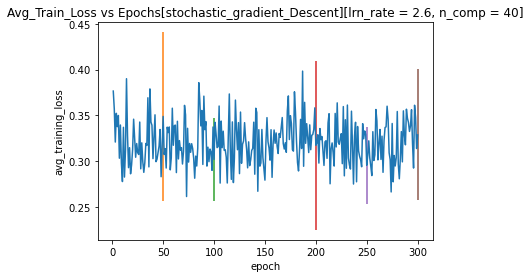

In [70]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = Avg_Train_loss.tolist()


iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "avg_training_loss")
plt.xlabel('epoch')
plt.ylabel('avg_training_loss')
plt.title('Avg_Train_Loss vs Epochs[stochastic_gradient_Descent][lrn_rate = 2.6, n_comp = 40]') 

b = [49,99,199,249,299]

for i in b:
    plt.errorbar(iters[i],costs[i],
            yerr = Std_Dev_Train[i],
            fmt='--')


plt.show() 

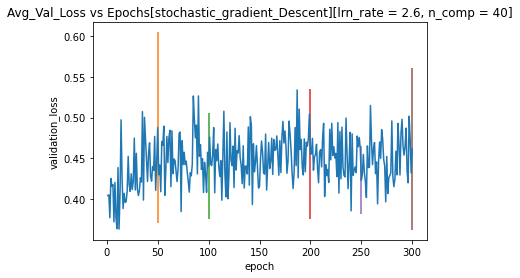

      0     1      2     3
0  81.0  10.0   19.0  39.0
1  17.0  71.0   34.0  26.0
2  23.0  18.0  105.0   4.0
3  43.0  24.0   20.0  63.0
          0         1         2         3
0  0.135678  0.016750  0.031826  0.065327
1  0.028476  0.118928  0.056951  0.043551
2  0.038526  0.030151  0.175879  0.006700
3  0.072027  0.040201  0.033501  0.105528


In [71]:
# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()
import pandas as pd
val_costs = Avg_Val_loss.tolist()

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "avg_validation_loss")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.title('Avg_Val_Loss vs Epochs[stochastic_gradient_Descent][lrn_rate = 2.6, n_comp = 40]')
b = [49,99,199,249,299]
for i in b:
    plt.errorbar(iters[i],val_costs[i],
            yerr = Std_Dev_Val[i])
plt.show() 

C = ConfusionMatrix(test_pred_list,test_fold_list)
#print(C)
#np.sum(C)
#import pandas as pd
print(pd.DataFrame(C))

perc_C = C/np.sum(C)
print(pd.DataFrame(perc_C))